In [6]:
import os
import torch
import torch.nn as nn
from PIL import Image
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader, random_split

In [69]:
class AugmentedDataset(Dataset):
    def __init__(self, directory, transform_0, transform_1):
        self.directory = directory
        self.transform_0 = transform_0
        self.transform_1 = transform_1
        self.data = []
        self.labels = []

        for label in [0, 1]:
            label_dir = f"{directory}/{label}"
            for img_path in os.listdir(label_dir):
                self.data.append(f"{label_dir}/{img_path}")
                self.labels.append(label)

        self.augment_data()

    def augment_data(self):
        target_count = 10000

        num_0 = sum(1 for label in self.labels if label == 0)
        while num_0 < target_count:
            self.data.append(self.data[self.labels.index(0)])
            self.labels.append(0)
            num_0 += 1

        num_1 = sum(1 for label in self.labels if label == 1)
        while num_1 < target_count:
            self.data.append(self.data[self.labels.index(1)])
            self.labels.append(1)
            num_1 += 1

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data[idx]
        label = self.labels[idx]
        img = Image.open(img_path).convert('RGB')

        if label == 0:
            img = self.transform_0(img)
        else:
            img = self.transform_1(img)

        return img, label

In [70]:
DATA_DIR = "../input/soccernet-legibility/final"
BATCH_SIZE = 32
IMG_SIZE = 64
TRAIN_RATIO = 0.8

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(64, scale=(0.8, 1.0)),  # Random crop, resized to 64x64
    transforms.Resize((64, 64)),  # Ensure final image size is 64x64
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize based on your data's stats
])

dataset = AugmentedDataset(directory=DATA_DIR, transform_0=transform_0, transform_1=transform)

train_size = int(TRAIN_RATIO * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

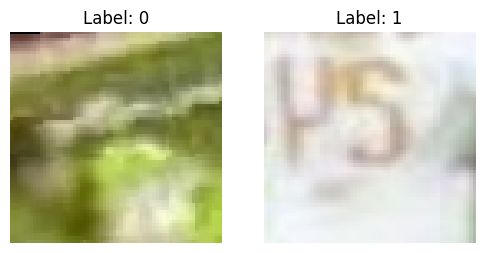

In [71]:
label_0_img, label_1_img = None, None

for images, labels in train_loader:
    for img, label in zip(images, labels):
        if label.item() == 0 and label_0_img is None:
            label_0_img = img
        elif label.item() == 1 and label_1_img is None:
            label_1_img = img
        if label_0_img is not None and label_1_img is not None:
            break
    if label_0_img is not None and label_1_img is not None:
        break

def unnormalize(tensor):
    return (tensor * 0.5) + 0.5

fig, axes = plt.subplots(1, 2, figsize=(6, 3))

axes[0].imshow(unnormalize(label_0_img).permute(1, 2, 0).numpy()) 
axes[0].set_title("Label: 0")
axes[0].axis("off")

axes[1].imshow(unnormalize(label_1_img).permute(1, 2, 0).numpy())
axes[1].set_title("Label: 1")
axes[1].axis("off")

plt.show()

In [72]:
class BinaryClassifier(nn.Module):
    def __init__(self):
        super(BinaryClassifier, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),  
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 8 * 8, 256),
            nn.ReLU(),
            nn.Linear(256, 1),  
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

In [73]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BinaryClassifier().to(device)

In [74]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [75]:
from tqdm.notebook import tqdm

def train_model(model, dataloader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)

        for images, labels in progress_bar:
            images, labels = images.to(device), labels.float().to(device)
            
            optimizer.zero_grad()
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(dataloader):.4f}")

In [76]:
train_model(model, train_loader, criterion, optimizer, epochs=15)

Epoch 1/15:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch [1/15], Loss: 0.0921


Epoch 2/15:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch [2/15], Loss: 0.0499


Epoch 3/15:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch [3/15], Loss: 0.0441


Epoch 4/15:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch [4/15], Loss: 0.0366


Epoch 5/15:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch [5/15], Loss: 0.0357


Epoch 6/15:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch [6/15], Loss: 0.0335


Epoch 7/15:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch [7/15], Loss: 0.0307


Epoch 8/15:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch [8/15], Loss: 0.0271


Epoch 9/15:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch [9/15], Loss: 0.0276


Epoch 10/15:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch [10/15], Loss: 0.0252


Epoch 11/15:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch [11/15], Loss: 0.0222


Epoch 12/15:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch [12/15], Loss: 0.0246


Epoch 13/15:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch [13/15], Loss: 0.0229


Epoch 14/15:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch [14/15], Loss: 0.0225


Epoch 15/15:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch [15/15], Loss: 0.0189


In [77]:
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).squeeze()
        
            predictions = (outputs >= 0.5).long()
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    accuracy = (correct / total) * 100
    return accuracy

In [78]:
print(f"Test set accuracy {evaluate_model(model, test_loader)} %")
print(f"Train set accuracy {evaluate_model(model, train_loader)} %")

Test set accuracy 99.05000000000001 %
Train set accuracy 99.5125 %
